# **Multi-agent supervisor**

In the previous example, we routed messages automatically based on the output of the initial researcher agent.


Below, we will create an agent group, with an agent supervisor to help delegate tasks.

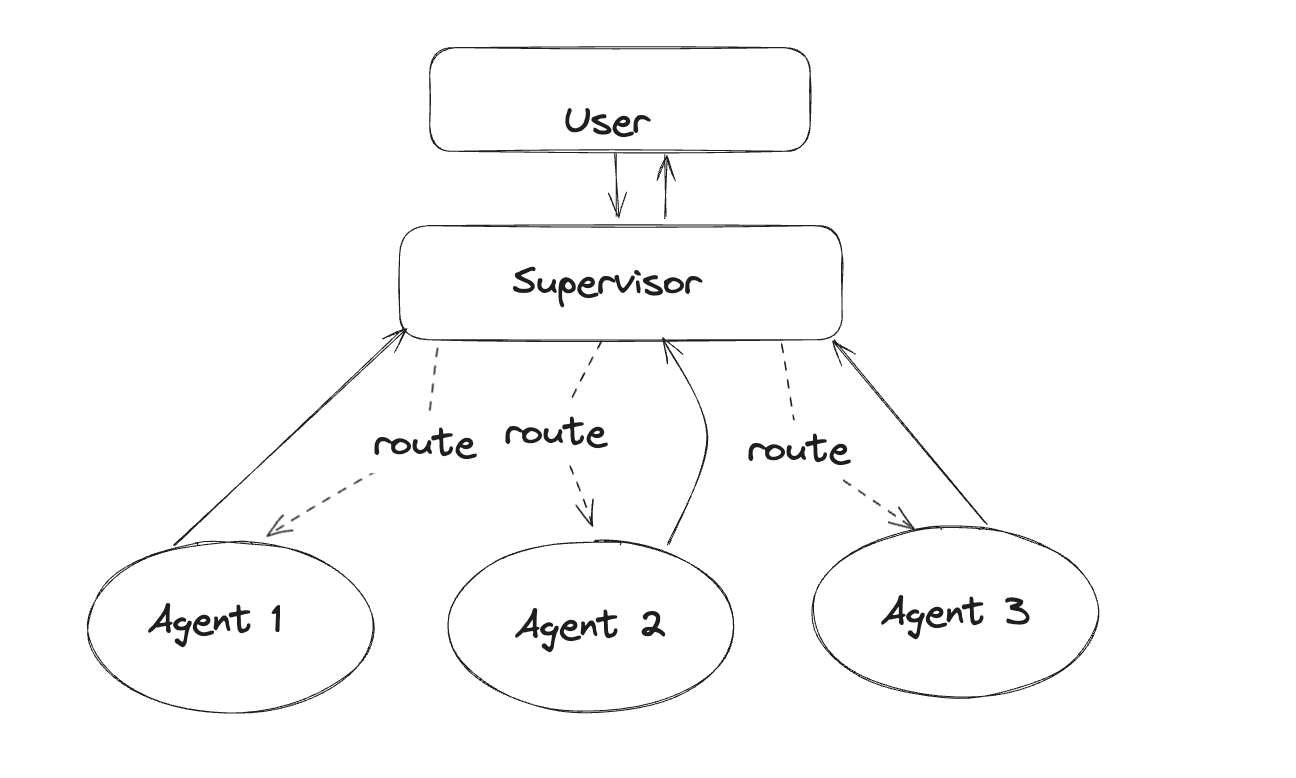

**NOTE:** To simplify the code in each agent node, we will use LangGraph's prebuilt `create_react_agent`.

## **Setup**

**Load your API keys**

In [1]:
from dotenv import load_dotenv

load_dotenv()

True

## **LLM**

In [2]:
from langchain_openai import ChatOpenAI
from langchain_ollama import ChatOllama
from langchain_groq import ChatGroq

In [3]:
llm = ChatGroq(model="llama-3.3-70b-versatile")
# llm = ChatOpenAI(model_name="gpt-4o-mini", temperature=0, streaming=True)

## **Create tools**

For this example, you will make an agent to do web research with a search engine, and one agent to create plots. 

Define the tools they'll use below:

In [4]:
from typing import Annotated

from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool
from langchain_experimental.utilities import PythonREPL

tavily_tool = TavilySearchResults(max_results=5)

# This executes code locally, which can be unsafe
repl = PythonREPL()


@tool
def python_repl_tool(
    code: Annotated[str, "The python code to execute to generate your chart."],
):
    """Use this to execute python code and do math. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user."""
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    result_str = f"Successfully executed:\n\`\`\`python\n{code}\n\`\`\`\nStdout: {result}"
    return result_str

## **Create Agent Supervisor**

It will use LLM with structured output to choose the next worker node OR finish processing.

In [10]:
from typing import Literal
from typing_extensions import TypedDict

from langchain_anthropic import ChatAnthropic
from langgraph.graph import MessagesState, END
from langgraph.types import Command
from langchain_core.messages import HumanMessage


members = ["researcher", "coder"]
# Our team supervisor is an LLM node. It just picks the next agent to process
# and decides when the work is completed
options = members + ["FINISH"]

system_prompt = (
    "You are a supervisor tasked with managing a conversation between the"
    f" following workers: {members}. Given the following user request,"
    " respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. When finished,"
    " respond with FINISH."
)


class Router(TypedDict):
    """Worker to route to next. If no workers needed, route to FINISH."""

    next: Literal[*options]


llm = llm


def supervisor_node(state: MessagesState) -> Command[Literal[*members, "__end__"]]:
    
    messages = [
        {"role": "system", "content": system_prompt},
    ] + state["messages"]

    response = llm.with_structured_output(Router).invoke(messages)

    goto = response["next"]
    
    if goto == "FINISH":
        goto = END

    return Command(update={
            "messages": [
                HumanMessage(content=goto, name="supervisor")
            ]
        },goto=goto)

## **Construct Graph**

We're ready to start building the graph. 

Below, define the state and worker nodes using the function we just defined.

In [6]:
from langchain_core.messages import HumanMessage
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import create_react_agent

In [11]:
### Create a Research Agent ###
research_agent = create_react_agent(
    llm, tools=[tavily_tool], state_modifier="You are a researcher. DO NOT do any math."
)

### Create the Research Node ###
def research_node(state: MessagesState) -> Command[Literal["supervisor"]]:
    result = research_agent.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="researcher")
            ]
        },
        goto="supervisor",
    )


### Create the Code Agent ###
# NOTE: THIS PERFORMS ARBITRARY CODE EXECUTION, WHICH CAN BE UNSAFE WHEN NOT SANDBOXED
code_agent = create_react_agent(llm, tools=[python_repl_tool])

### Create the Code Node ###
def code_node(state: MessagesState) -> Command[Literal["supervisor"]]:
    result = code_agent.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="coder")
            ]
        },
        goto="supervisor",
    )


builder = StateGraph(MessagesState)
builder.add_edge(START, "supervisor")
builder.add_node("supervisor", supervisor_node)
builder.add_node("researcher", research_node)
builder.add_node("coder", code_node)
graph = builder.compile()

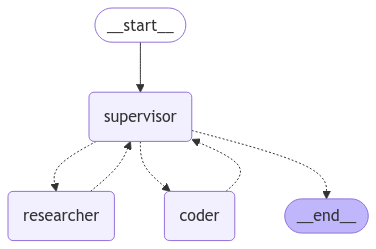

In [12]:
from IPython.display import display, Image

display(Image(graph.get_graph().draw_mermaid_png()))

### **Invoke the team**

With the graph created, we can now invoke it and see how it performs!

In [13]:
for s in graph.stream(
    {"messages": [("user", "What's the square root of 42?")]}, subgraphs=True
):
    print(s)
    print("----")

((), {'supervisor': {'messages': [HumanMessage(content='researcher', additional_kwargs={}, response_metadata={}, name='supervisor')]}})
----
(('researcher:f75c2987-76e2-9fbb-6de6-c6bfa47b4381',), {'agent': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_6nw0', 'function': {'arguments': '{"query": "square root of 42"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 61, 'prompt_tokens': 305, 'total_tokens': 366, 'completion_time': 0.221818182, 'prompt_time': 0.034947767, 'queue_time': 0.010278616000000004, 'total_time': 0.256765949}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_c0cfa69934', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-78ea01cc-0ba6-4b9e-8726-101b5ea37fb3-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'square root of 42'}, 'id': 'call_6nw0', 'type': 'tool_call'}], usage_metadata={'input_tokens': 305, 'outpu

# **Hierarchical Agent Teams**

In our previous example (`Agent Supervisor`), we introduced the concept of a single `supervisor node` to route work between different worker nodes.

But what if the job for a single worker becomes too complex? What if the number of workers becomes too large?

For some applications, the system may be more effective if work is distributed hierarchically.

**You can do this by composing different subgraphs and creating a top-level supervisor, along with mid-level supervisors.**

To do this, let's build a simple research assistant! 

The graph will look something like the following:

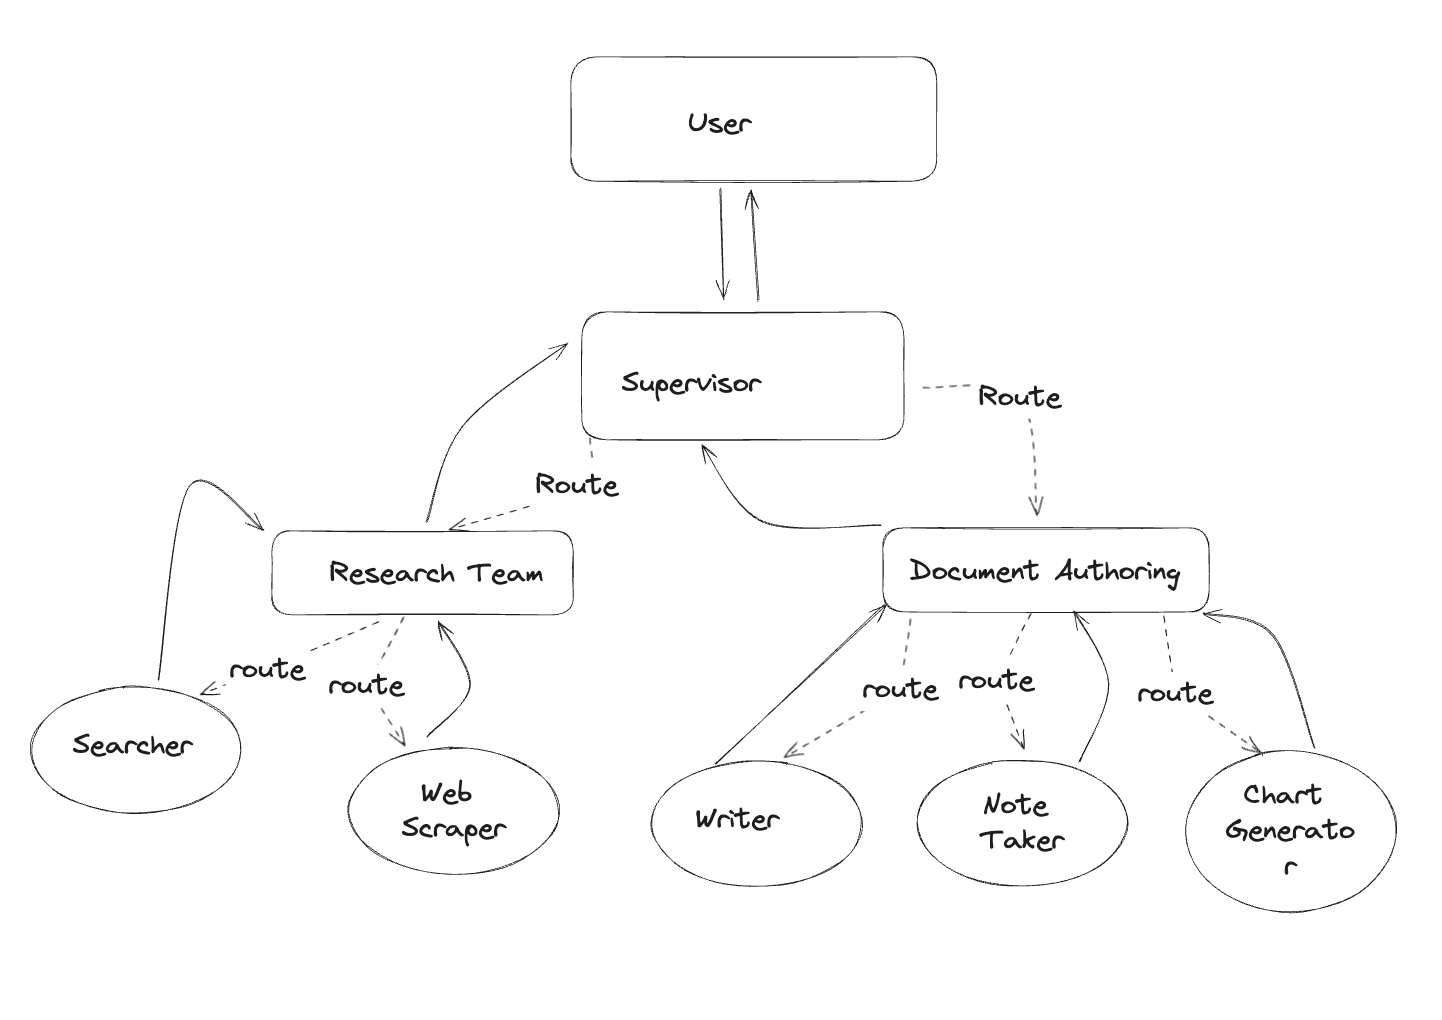

This notebook is inspired by the paper [AutoGen: Enabling Next-Gen LLM Applications via Multi-Agent Conversation](https://arxiv.org/abs/2308.08155), by Wu, et. al. 

**In the rest of this notebook, you will:**

1. Define the agents' tools to access the web and write files
2. Define some utilities to help create the graph and agents
3. Create and define each team (web research + doc writing)
4. Compose everything together.

## **Setup**

**Load your API keys**

In [ ]:
from dotenv import load_dotenv

load_dotenv()

True

## **LLM**

In [ ]:
from langchain_openai import ChatOpenAI
from langchain_ollama import ChatOllama
from langchain_groq import ChatGroq

In [ ]:
llm = ChatGroq(model="llama-3.1-70b-versatile")
# llm = ChatOpenAI(model_name="gpt-4o-mini", temperature=0)

## **Create Tools**

Each team will be composed of one or more agents each with one or more tools. 

Below, define all the tools to be used by your different teams.

We'll start with the research team.

### **ResearchTeam tools**

The research team can use a `search engine` and `url scraper` to find information on the web. 

Feel free to add additional functionality below to boost the team performance!

In [ ]:
from typing import Annotated, List

from langchain_community.document_loaders import WebBaseLoader
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool

search_tool = TavilySearchResults(max_results=5)


@tool
def scrape_webpages(urls: List[str]) -> str:
    """Use requests and bs4 to scrape the provided web pages for detailed information."""
    loader = WebBaseLoader(urls)
    docs = loader.load()
    return "\n\n".join(
        [
            f'<Document name="{doc.metadata.get("title", "")}">\n{doc.page_content}\n</Document>'
            for doc in docs
        ]
    )

USER_AGENT environment variable not set, consider setting it to identify your requests.


### **Document writing team tools**

Next up, we will give some tools for the doc writing team to use. We define some bare-bones file-access tools below.

**Notes:** 

- This gives the agents access to your file-system, which can be unsafe. 
- We also haven't optimized the tool descriptions for performance.

In [ ]:
from pathlib import Path
from tempfile import TemporaryDirectory
from typing import Dict, Optional

from langchain_experimental.utilities import PythonREPL
from typing_extensions import TypedDict

_TEMP_DIRECTORY = TemporaryDirectory()
WORKING_DIRECTORY = Path(_TEMP_DIRECTORY.name)


@tool
def create_outline(
    points: Annotated[List[str], "List of main points or sections."],
    file_name: Annotated[str, "File path to save the outline."],
) -> Annotated[str, "Path of the saved outline file."]:
    """Create and save an outline."""
    
    with (WORKING_DIRECTORY / file_name).open("w") as file:
        for i, point in enumerate(points):
            file.write(f"{i + 1}. {point}\n")
    return f"Outline saved to {file_name}"


@tool
def read_document(
    file_name: Annotated[str, "File path to read the document from."],
    start: Annotated[Optional[int], "The start line. Default is 0"] = None,
    end: Annotated[Optional[int], "The end line. Default is None"] = None,
) -> str:
    """Read the specified document."""
    with (WORKING_DIRECTORY / file_name).open("r") as file:
        lines = file.readlines()
    if start is not None:
        start = 0
    return "\n".join(lines[start:end])


@tool
def write_document(
    content: Annotated[str, "Text content to be written into the document."],
    file_name: Annotated[str, "File path to save the document."],
) -> Annotated[str, "Path of the saved document file."]:
    """Create and save a text document."""
    with (WORKING_DIRECTORY / file_name).open("w") as file:
        file.write(content)
    return f"Document saved to {file_name}"


@tool
def edit_document(
    file_name: Annotated[str, "Path of the document to be edited."],
    inserts: Annotated[
        Dict[int, str],
        "Dictionary where key is the line number (1-indexed) and value is the text to be inserted at that line.",
    ],
) -> Annotated[str, "Path of the edited document file."]:
    """Edit a document by inserting text at specific line numbers."""

    with (WORKING_DIRECTORY / file_name).open("r") as file:
        lines = file.readlines()

    sorted_inserts = sorted(inserts.items())

    for line_number, text in sorted_inserts:
        if 1 <= line_number <= len(lines) + 1:
            lines.insert(line_number - 1, text + "\n") #Converts 1-indexed line number to 0-indexed list index
        else:
            return f"Error: Line number {line_number} is out of range."

    with (WORKING_DIRECTORY / file_name).open("w") as file:
        file.writelines(lines)

    return f"Document edited and saved to {file_name}"


# Warning: This executes code locally, which can be unsafe when not sandboxed

repl = PythonREPL()


@tool
def python_repl_tool(
    code: Annotated[str, "The python code to execute to generate your chart."],
):
    """Use this to execute python code. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user."""
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    return f"Successfully executed:\n\`\`\`python\n{code}\n\`\`\`\nStdout: {result}"

## **Helper Utilities**

We are going to create a few utility functions to make it more concise when we want to:

1. Create a worker agent.
2. Create a supervisor for the sub-graph.

These will simplify the graph compositional code at the end for us so it's easier to see what's going on.

In [ ]:
from typing import Annotated, Sequence, List
from typing_extensions import TypedDict

from langchain_core.messages import BaseMessage

from langgraph.graph.message import add_messages


class GraphState(TypedDict):
    """
    Graph state is a dictionary that contains information we want to propagate to, and modify in, each graph node.
    """

    messages: Annotated[Sequence[BaseMessage], add_messages] # User question
    next: str  # Next node called by the supervisor

In [ ]:
from typing import List, Optional, Literal
from langchain_core.language_models.chat_models import BaseChatModel

from langgraph.graph import StateGraph, MessagesState, START, END
from langgraph.types import Command
from langchain_core.messages import HumanMessage, trim_messages


def make_supervisor_node(llm: BaseChatModel, members: list[str]) -> str:
    options = ["FINISH"] + members
    system_prompt = (
        "You are a supervisor tasked with managing a conversation between the"
        f" following workers: {members}. Given the following user request,"
        " respond with the worker to act next. Each worker will perform a"
        " task and respond with their results and status. When finished,"
        " respond with FINISH."
    )

    class Router(TypedDict):
        """Worker to route to next. If no workers needed, route to FINISH."""

        next: Literal[*options]

    def supervisor_node(state: GraphState) -> Command[Literal[*members, "__end__"]]:
        """An LLM-based router."""
        messages = [
            {"role": "system", "content": system_prompt},
        ] + state["messages"]

        response = llm.with_structured_output(Router).invoke(messages)

        goto = response["next"]
        
        if goto == "FINISH":
            goto = END

        return Command(update={'next':goto},goto=goto)

    return supervisor_node

## **Define Agent Teams**

Now we can get to define our hierarchical teams. "Choose your player!"

### **Research Team**

The research team will have a search agent and a web scraping "research_agent" as the two worker nodes. 

Let's create those, as well as the team supervisor.

In [ ]:
from langchain_core.messages import HumanMessage
from langchain_openai import ChatOpenAI
from langgraph.prebuilt import create_react_agent

llm = llm

search_agent = create_react_agent(llm, tools=[search_tool])


def search_node(state: GraphState) -> Command[Literal["supervisor"]]:
    result = search_agent.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="search")
            ]
        },
        # We want our workers to ALWAYS "report back" to the supervisor when done
        goto="supervisor",
    )


web_scraper_agent = create_react_agent(llm, tools=[scrape_webpages])


def web_scraper_node(state: GraphState) -> Command[Literal["supervisor"]]:
    result = web_scraper_agent.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="web_scraper")
            ]
        },
        # We want our workers to ALWAYS "report back" to the supervisor when done
        goto="supervisor",
    )


research_supervisor_node = make_supervisor_node(llm, ["search", "web_scraper"])

Now that we've created the necessary components, defining their interactions is easy. 

Add the nodes to the team graph, and define the edges, which determine the transition criteria.

In [ ]:
research_builder = StateGraph(GraphState)
research_builder.add_node("supervisor", research_supervisor_node)
research_builder.add_node("search", search_node)
research_builder.add_node("web_scraper", web_scraper_node)

research_builder.add_edge(START, "supervisor")
research_graph = research_builder.compile()

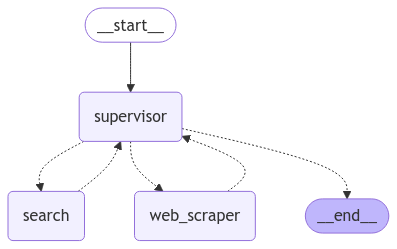

In [ ]:
from IPython.display import Image, display

display(Image(research_graph.get_graph().draw_mermaid_png()))

We can give this team work directly. Try it out below.

In [ ]:
for s in research_graph.stream(
    {"messages": [("user", "when is Taylor Swift's next tour?")]},
    {"recursion_limit": 100},
):
    print(s)
    print("---")

2024-12-11 03:30:08,578 - INFO: HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


{'supervisor': None}
---


2024-12-11 03:30:09,129 - INFO: HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-12-11 03:30:12,576 - INFO: HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


{'search': {'messages': [HumanMessage(content="Taylor Swift's next tour, the **Eras Tour**, will resume on **October 18, 2024**, at Hard Rock Stadium in Miami, Florida. The final date of this leg of the tour is scheduled for **December 8, 2024**, at BC Place in Vancouver, Canada. \n\nIn addition to the North American dates, she will also be performing in various international locations, including cities in Europe, Asia, and South America throughout 2024. \n\nFor more details, you can check out the full schedule [here](https://www.azcentral.com/story/entertainment/music/2024/09/10/taylor-swift-eras-tour-dates-2024/75109891007/).", additional_kwargs={}, response_metadata={}, name='search', id='cbf1d5db-6312-4d8f-afdc-a89fe8dbc26c')]}}
---


2024-12-11 03:30:14,695 - INFO: HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


{'supervisor': None}
---


In [ ]:
for s in research_graph.stream(
    {"messages": [("user", "when is Taylor Swift's next tour?")]},
    {"recursion_limit": 100},
):
    print(s)
    print("---")

2024-12-11 16:38:59,670 - INFO: HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


{'supervisor': {'next': 'search'}}
---


2024-12-11 16:39:00,182 - INFO: HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-12-11 16:39:03,388 - INFO: HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


{'search': {'messages': [HumanMessage(content='Taylor Swift\'s next tour, the "Eras Tour," will have several international dates in 2024. Here are some key details:\n\n- The tour will kick off in Tokyo, Japan, on February 7, 2024, and will include multiple dates in Australia, Europe, and North America.\n- The final leg of the tour in North America starts on October 18, 2024, in Miami, Florida, and concludes on December 8, 2024, in Vancouver, Canada.\n\nFor a complete list of dates and locations, you can check out the full details in the articles linked below:\n\n1. [WUSA9](https://www.wusa9.com/article/news/nation-world/taylor-swift-announces-more-us-dates-eras-tour-2024/507-30d389c1-3710-4d04-a698-5895fa182042)\n2. [AZCentral](https://www.azcentral.com/story/entertainment/music/2024/09/10/taylor-swift-eras-tour-dates-2024/75109891007/)\n3. [Pitchfork](https://pitchfork.com/news/taylor-swift-adds-2024-north-american-dates-to-eras-tour/)', additional_kwargs={}, response_metadata={}, nam

2024-12-11 16:39:07,656 - INFO: HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


{'supervisor': {'next': '__end__'}}
---


## **Document Writing Team**

Create the document writing team below using a similar approach. This time, we will give each agent access to different file-writing tools.

**Note that we are giving file-system access to our agent here, which is not safe in all cases.**

In [ ]:
llm = llm

doc_writer_agent = create_react_agent(
    llm,
    tools=[write_document, edit_document, read_document],
    state_modifier=(
        "You can read, write and edit documents based on note-taker's outlines. "
        "Don't ask follow-up questions."
    ),
)


def doc_writing_node(state: GraphState) -> Command[Literal["supervisor"]]:
    result = doc_writer_agent.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="doc_writer")
            ]
        },
        # We want our workers to ALWAYS "report back" to the supervisor when done
        goto="supervisor",
    )


note_taking_agent = create_react_agent(
    llm,
    tools=[create_outline, read_document],
    state_modifier=(
        "You can read documents and create outlines for the document writer. "
        "Don't ask follow-up questions."
    ),
)


def note_taking_node(state: GraphState) -> Command[Literal["supervisor"]]:
    result = note_taking_agent.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="note_taker")
            ]
        },
        # We want our workers to ALWAYS "report back" to the supervisor when done
        goto="supervisor",
    )


chart_generating_agent = create_react_agent(
    llm, tools=[read_document, python_repl_tool]
)


def chart_generating_node(state: GraphState) -> Command[Literal["supervisor"]]:
    result = chart_generating_agent.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(
                    content=result["messages"][-1].content, name="chart_generator"
                )
            ]
        },
        # We want our workers to ALWAYS "report back" to the supervisor when done
        goto="supervisor",
    )


doc_writing_supervisor_node = make_supervisor_node(
    llm, ["doc_writer", "note_taker", "chart_generator"]
)

With the node objects themselves created, we can form the graph.

In [ ]:
# Create the graph here
paper_writing_builder = StateGraph(GraphState)
paper_writing_builder.add_node("supervisor", doc_writing_supervisor_node)
paper_writing_builder.add_node("doc_writer", doc_writing_node)
paper_writing_builder.add_node("note_taker", note_taking_node)
paper_writing_builder.add_node("chart_generator", chart_generating_node)

paper_writing_builder.add_edge(START, "supervisor")
paper_writing_graph = paper_writing_builder.compile()

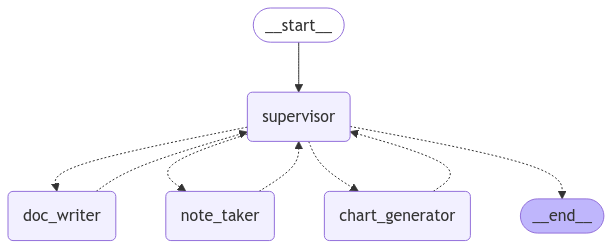

In [ ]:
from IPython.display import Image, display

display(Image(paper_writing_graph.get_graph().draw_mermaid_png()))

In [ ]:
for s in paper_writing_graph.stream(
    {
        "messages": [
            (
                "user",
                "Write an outline for poem about cats and then write the poem to disk.",
            )
        ]
    },
    {"recursion_limit": 100},
):
    print(s)
    print("---")

2024-12-11 17:24:01,661 - INFO: HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


{'supervisor': {'next': 'doc_writer'}}
---


2024-12-11 17:24:05,206 - INFO: HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-12-11 17:24:14,524 - INFO: HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-12-11 17:24:15,473 - INFO: HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


{'doc_writer': {'messages': [HumanMessage(content='The outline for the poem about cats has been saved to "cats_poem_outline.txt," and the poem itself has been saved to "cats_poem.txt."', additional_kwargs={}, response_metadata={}, name='doc_writer', id='b15ae308-c7bf-40cd-8355-c8b3c0990cb3')]}}
---


2024-12-11 17:24:16,008 - INFO: HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


{'supervisor': {'next': 'note_taker'}}
---


2024-12-11 17:24:17,326 - INFO: HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-12-11 17:24:20,668 - INFO: HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-12-11 17:24:21,412 - INFO: HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


{'note_taker': {'messages': [HumanMessage(content='The outline for the poem about cats has been saved to "cats_poem_outline.txt," and the poem itself has been saved to "cats_poem.txt."', additional_kwargs={}, response_metadata={}, name='note_taker', id='e033c37d-9132-4ee0-a67f-4a21590e3a49')]}}
---


2024-12-11 17:24:22,028 - INFO: HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


{'supervisor': {'next': 'chart_generator'}}
---


2024-12-11 17:24:23,588 - INFO: HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-12-11 17:24:30,046 - INFO: HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


{'chart_generator': {'messages': [HumanMessage(content="### Outline for Poem about Cats\n\n1. **Introduction to cats**\n2. **Physical characteristics**\n3. **Playful nature**\n4. **Mysterious behavior**\n5. **Affectionate moments**\n6. **Conclusion about cats**\n\n---\n\n### Poem about Cats\n\n1. Whiskers twitching in the light,  \n2. Soft paws padding through the night,  \n3. Eyes like lanterns, bright and wide,  \n4. In their world, they take great pride.  \n\n5. Chasing shadows, leaping high,  \n6. With a pounce, they catch the sky,  \n7. Playful spirits, full of grace,  \n8. In every corner, they find their space.  \n\n9. Mysterious creatures, wise and sly,  \n10. With a gentle purr, they draw you nigh,  \n11. Secrets held in every glance,  \n12. In their presence, we find romance.  \n\n13. Curled up close, a warm embrace,  \n14. In their love, we find our place,  \n15. Furry friends, both wild and tame,  \n16. In our hearts, they stake their claim.  \n\n17. So here's to cats, both

2024-12-11 17:24:30,541 - INFO: HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


{'supervisor': {'next': '__end__'}}
---


## **Add Layers**

In this design, we are enforcing a top-down planning policy. We've created two graphs already, but we have to decide how to route work between the two.

We'll create a third graph to orchestrate the previous two, and add some connectors to define how this top-level state is shared between the different graphs.

In [ ]:
from langchain_core.messages import BaseMessage

llm = llm

teams_supervisor_node = make_supervisor_node(llm, ["research_team", "writing_team"])

In [ ]:
def call_research_team(state: GraphState) -> Command[Literal["supervisor"]]:
    response = research_graph.invoke({"messages": state["messages"][-1]})
    return Command(
        update={
            "messages": [
                HumanMessage(
                    content=response["messages"][-1].content, name="research_team"
                )
            ]
        },
        goto="supervisor",
    )


def call_paper_writing_team(state: GraphState) -> Command[Literal["supervisor"]]:
    response = paper_writing_graph.invoke({"messages": state["messages"][-1]})
    return Command(
        update={
            "messages": [
                HumanMessage(
                    content=response["messages"][-1].content, name="writing_team"
                )
            ]
        },
        goto="supervisor",
    )


# Define the graph.
super_builder = StateGraph(MessagesState)
super_builder.add_node("supervisor", teams_supervisor_node)
super_builder.add_node("research_team", call_research_team)
super_builder.add_node("writing_team", call_paper_writing_team)

super_builder.add_edge(START, "supervisor")
super_graph = super_builder.compile()

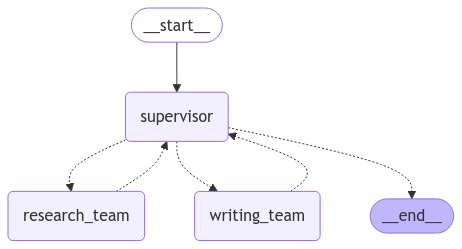

In [ ]:
from IPython.display import Image, display

display(Image(super_graph.get_graph().draw_mermaid_png()))

In [ ]:
for s in super_graph.stream(
    {
        "messages": [
            ("user", "Research AI agents and write a brief report about them.")
        ],
    },
    {"recursion_limit": 150},
):
    print(s)
    print("---")

2024-12-11 17:38:55,285 - INFO: HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


{'supervisor': {'next': 'research_team'}}
---


2024-12-11 17:38:56,102 - INFO: HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-12-11 17:38:56,819 - INFO: HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-12-11 17:39:00,300 - INFO: HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-12-11 17:39:17,697 - INFO: HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-12-11 17:39:18,312 - INFO: HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-12-11 17:39:26,704 - INFO: HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-12-11 17:39:48,845 - INFO: HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


{'research_team': {'messages': [HumanMessage(content="### Report on AI Agents\n\n#### Introduction\nAI agents are intelligent software programs designed to perform tasks autonomously or semi-autonomously, leveraging artificial intelligence technologies. They are increasingly becoming integral to various industries, enhancing efficiency, personalization, and decision-making processes.\n\n#### Types of AI Agents\n1. **Single-Agent Systems**: These operate independently to perform specific tasks, such as virtual assistants (e.g., Siri, Alexa).\n2. **Multi-Agent Systems**: These involve multiple agents working collaboratively to achieve complex goals, often seen in applications like automated trading systems or smart grid management.\n\n#### Popular AI Agents in 2023\nSeveral AI agents have gained prominence in 2023, including:\n- **LLMops**: A versatile agent with advanced language processing capabilities, applicable across various industries, particularly in customer service and healthca

2024-12-11 17:39:49,559 - INFO: HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


{'supervisor': {'next': 'writing_team'}}
---


2024-12-11 17:39:50,314 - INFO: HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-12-11 17:40:05,431 - INFO: HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-12-11 17:40:06,275 - INFO: HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-12-11 17:40:07,267 - INFO: HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-12-11 17:40:08,571 - INFO: HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-12-11 17:40:09,322 - INFO: HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-12-11 17:40:09,875 - INFO: HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-12-11 17:40:11,266 - INFO: HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-12-11 17:40:11,782 - INFO: HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 

{'writing_team': {'messages': [HumanMessage(content='The report on AI agents has been created and saved as "AI_Agents_Report_2023.txt," and the outline for the report has been saved as "AI_Agents_Report_2023_Outline.txt." If you need any further assistance or modifications, feel free to ask!', additional_kwargs={}, response_metadata={}, name='writing_team', id='71c83477-5318-49b0-9c67-0824bfabae09')]}}
---


2024-12-11 17:40:12,524 - INFO: HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


{'supervisor': {'next': '__end__'}}
---
